# Imports

In [1]:
# %%bash

# git clone https://github.com/Qiwei97/Gym-PM.git
# cd Gym-PM
# pip install -e .

In [2]:
# Import Modules
import numpy as np
import gym
from gym.wrappers.normalize import NormalizeReward

import gym_pm
from gym_pm.utils import evaluate_baseline, evaluate_policy, plot_metrics
from gym_pm.envs import Railv2_Env

import ray
from ray.tune.registry import register_env
from ray.rllib.agents import impala

# Environment

In [3]:
def env_wrapper(env_config):

  wrapped_env = Railv2_Env(**env_config) # Use the appropriate env
  wrapped_env = NormalizeReward(wrapped_env)

  return wrapped_env  # return an env instance

env_name = "Rail-v2"
register_env(env_name, env_wrapper)

# Training

In [4]:
config = impala.DEFAULT_CONFIG.copy()
# Training Params
config['seed'] = 1
config['batch_mode'] = 'complete_episodes'
config['exploration_config'] = {'type': 'SoftQ'}
# Architecture
config['replay_proportion'] = 0.3
config['replay_buffer_num_slots'] = 1000
config['grad_clip'] = 100
config['vtrace_clip_rho_threshold'] = 5.
config['vtrace_clip_pg_rho_threshold'] = 5.
# Multiprocessing
config["num_gpus"] = 0
config["num_workers"] = 32
# Preprocessing
config["observation_filter"] = 'MeanStdFilter'
config['preprocessor_pref'] = 'rllib'

trainer = impala.ImpalaTrainer(config=config, env=env_name)

(RolloutWorker pid=8514) 2022-03-01 10:37:53,232	WARNING deprecation.py:46 -- DeprecationWarning: `SampleBatch['is_training']` has been deprecated. Use `SampleBatch.is_training` instead. This will raise an error in the future!
2022-03-01 10:37:54,934	WARNING deprecation.py:46 -- DeprecationWarning: `SampleBatch['is_training']` has been deprecated. Use `SampleBatch.is_training` instead. This will raise an error in the future!
2022-03-01 10:37:56,417	INFO trainable.py:127 -- Trainable.setup took 27.200 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.


In [5]:
results = []

for i in range(int(1000)):

  res = trainer.train()
  results.append(res)

  if (i+1) % 10 == 0:
    print('Iter: {} Reward: {:.2f}'.format(i+1, res['episode_reward_mean']))

trainer.save('Models/Railv2/Impala')

2022-03-01 10:38:41,600	WARNING deprecation.py:46 -- DeprecationWarning: `slice` has been deprecated. Use `SampleBatch[start:stop]` instead. This will raise an error in the future!


Iter: 10 Reward: 601.42
Iter: 20 Reward: 48.04
Iter: 30 Reward: 131.57
Iter: 40 Reward: 192.49
Iter: 50 Reward: 190.45
Iter: 60 Reward: 197.38
Iter: 70 Reward: 206.57
Iter: 80 Reward: 211.70
Iter: 90 Reward: 221.08
Iter: 100 Reward: 232.97
Iter: 110 Reward: 238.54
Iter: 120 Reward: 249.64
Iter: 130 Reward: 256.18
Iter: 140 Reward: 260.05
Iter: 150 Reward: 267.25
Iter: 160 Reward: 276.35
Iter: 170 Reward: 282.52
Iter: 180 Reward: 292.35
Iter: 190 Reward: 300.67
Iter: 200 Reward: 305.89
Iter: 210 Reward: 303.83
Iter: 220 Reward: 318.14
Iter: 230 Reward: 323.37
Iter: 240 Reward: 330.10
Iter: 250 Reward: 336.97
Iter: 260 Reward: 345.48
Iter: 270 Reward: 349.53
Iter: 280 Reward: 354.36
Iter: 290 Reward: 359.36
Iter: 300 Reward: 364.87
Iter: 310 Reward: 376.40
Iter: 320 Reward: 378.98
Iter: 330 Reward: 386.98
Iter: 340 Reward: 396.06
Iter: 350 Reward: 394.93
Iter: 360 Reward: 403.19
Iter: 370 Reward: 407.86
Iter: 380 Reward: 412.55
Iter: 390 Reward: 416.49
Iter: 400 Reward: 424.31
Iter: 410 

'Models/Railv2/Impala/checkpoint_001000/checkpoint-1000'

# Evaluation

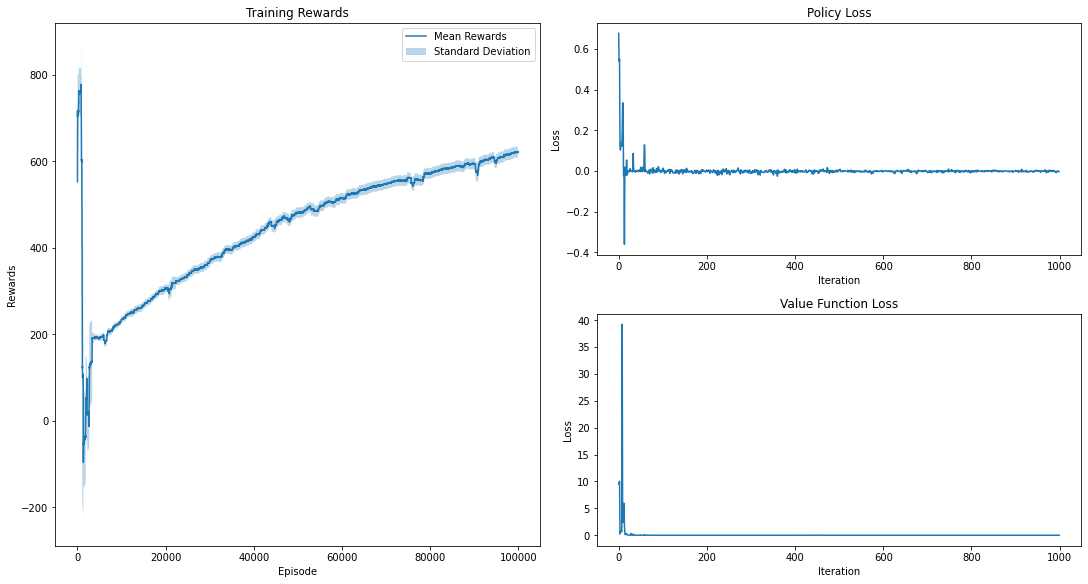

In [6]:
plot_metrics(results)

In [7]:
# trainer = impala.ImpalaTrainer(config=config, env=env_name)
# trainer.restore('Models/Railv2/Impala/checkpoint_001000/checkpoint-1000')

In [8]:
eval_env = Railv2_Env(config, split='Test')

baseline = evaluate_baseline(eval_env,
                             repair_policy=1, 
                             repair_interval=10)

result = evaluate_policy(eval_env, trainer)

print('Baseline: {}'.format(baseline.reward.mean()))
print('Agent Performance: {}'.format(result.reward.mean()))

2022-03-01 19:42:58,478	WARNING deprecation.py:46 -- DeprecationWarning: `compute_action` has been deprecated. Use `compute_single_action` instead. This will raise an error in the future!


Baseline: 87.08100827400423
Agent Performance: 90.25784106215124


In [9]:
result.to_csv('Output/Railv2_impala.csv')

In [14]:
agent, base0, base10 = [], [], []

for _ in range(5):
    agent.append(evaluate_policy(eval_env, trainer).reward.mean())
    base0.append(evaluate_baseline(eval_env,
                                   repair_policy=0).reward.mean())
    base10.append(evaluate_baseline(eval_env,
                                    repair_policy=1, 
                                    repair_interval=10).reward.mean())

print(np.mean(agent))
print(np.mean(base0))
print(np.mean(base10))

90.18356744275545
81.43313450067346
87.04637290744661


In [11]:
# Outperforms Policy 0

<BarContainer object of 20 artists>

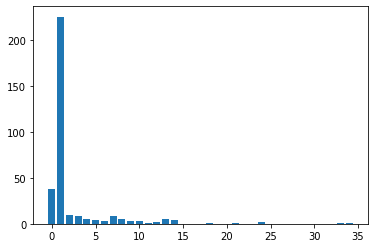

In [12]:
import matplotlib.pyplot as plt

result.action = result.action.shift(-1)

ttf_dist = result[result.action == 0].ttf.value_counts()
plt.bar(ttf_dist.index, ttf_dist)

<BarContainer object of 41 artists>

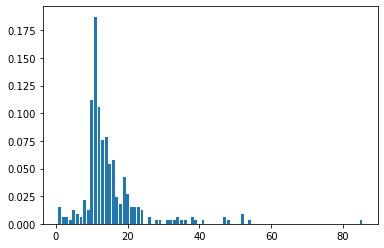

In [13]:
age_dist = result[result.action == 0].age.value_counts(normalize=True)
plt.bar(age_dist.index, age_dist)